In [1]:
import os.path as osp
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from changeit3d.in_out.basics import unpickle_data

sns.set()

def format_string(x):
    x = round(x * 100, 1)
    x = format(x, '.1f') + '%'
    return x

In [2]:
model_to_modality = {
    # 'imnet': 'implicit',               
    'sgf': 'pointcloud',
    'pcae': 'pointcloud',    
    'resnet101': 'image',
    'openai_clip-vit-large-patch14': 'image',
    'laion_CLIP-ViT-H-14-laion2B-s32B-b79K': 'image'
    }


architecture = "transformer"  # Or lstm (below)
# architecture = "lstm"

# assumes you have downloaded the pretrained nets 
top_data_dir = f'/home/panos/Git_Repos/changeit3d/changeit3d/data/pretrained/listeners/all_shapetalk_classes/rs_2022/single_utter/{architecture}_based' 
top_multi_utter_dir = f'/home/panos/Git_Repos/changeit3d/changeit3d/data/pretrained/listeners/all_shapetalk_classes/rs_2022/multi_utter/{architecture}_based' 

locations = dict()
for model, modality in model_to_modality.items():
    location = top_data_dir + "/" +f'latent_{model}_based/analysis_of_trained_listener.pkl'
    if osp.exists(location):
        locations[model] = location
    else:
        print(location)

In [3]:
table_df = []
model_to_res = dict()

for model, infile in locations.items():
    data = next(unpickle_data(infile))
    keep = [model, model_to_modality[model]]
     
    check = [data['test']['accuracy'], 
             data['test']['accuracy_on_easy_excluding_sg_examples'],
             data['test']['accuracy_on_hard_excluding_sg_examples'],
             data['test']['accuracy_per_saliency'][0],
             data['test']['accuracy_per_saliency'][4]]
             
    for datum in check:
        keep.append(format_string(datum))    
    
    # multi-utter
    multi_file = top_multi_utter_dir  + "/" + f"latent_{model}_based/analysis_of_trained_listener.pkl" 
    if osp.exists(multi_file):        
        mdf = next(unpickle_data(multi_file))
        keep.append(format_string(mdf['test']['accuracy']))
    else:
        keep.append('-')
    
    table_df.append(keep)
    model_to_res[model] = data
    
table_df = pd.DataFrame(table_df)

In [4]:
table_df.columns = ['Shape Backbone', 'Modality', 'Overall', 'Easy', 'Hard', '1st-Utter', 'Last-Utter', 'Multi-Utter']
print(table_df.to_markdown(index=False, floatfmt="#.1f"))

| Shape Backbone                        | Modality   | Overall   | Easy   | Hard   | 1st-Utter   | Last-Utter   | Multi-Utter   |
|:--------------------------------------|:-----------|:----------|:-------|:-------|:------------|:-------------|:--------------|
| sgf                                   | pointcloud | 69.7%     | 73.8%  | 65.6%  | 73.9%       | 66.8%        | 75.1%         |
| pcae                                  | pointcloud | 71.4%     | 75.3%  | 67.4%  | 75.7%       | 68.8%        | 74.9%         |
| resnet101                             | image      | 72.9%     | 75.8%  | 69.9%  | 76.9%       | 69.6%        | 80.2%         |
| openai_clip-vit-large-patch14         | image      | 73.6%     | 76.7%  | 70.5%  | 77.4%       | 71.5%        | 80.1%         |
| laion_CLIP-ViT-H-14-laion2B-s32B-b79K | image      | 75.1%     | 78.2%  | 72.0%  | 79.6%       | 72.1%        | 82.2%         |


In [5]:
print(table_df.to_latex(index=False))

\begin{tabular}{llllllll}
\toprule
                       Shape Backbone &   Modality & Overall &  Easy &  Hard & 1st-Utter & Last-Utter & Multi-Utter \\
\midrule
                                  sgf & pointcloud &   69.7\% & 73.8\% & 65.6\% &     73.9\% &      66.8\% &       75.1\% \\
                                 pcae & pointcloud &   71.4\% & 75.3\% & 67.4\% &     75.7\% &      68.8\% &       74.9\% \\
                            resnet101 &      image &   72.9\% & 75.8\% & 69.9\% &     76.9\% &      69.6\% &       80.2\% \\
        openai\_clip-vit-large-patch14 &      image &   73.6\% & 76.7\% & 70.5\% &     77.4\% &      71.5\% &       80.1\% \\
laion\_CLIP-ViT-H-14-laion2B-s32B-b79K &      image &   75.1\% & 78.2\% & 72.0\% &     79.6\% &      72.1\% &       82.2\% \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1376641/714041516.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_df.to_latex(index=False))


In [6]:
add_clip_no_ft = True

In [7]:
per_class_accs = dict()
means = dict()

for model in ['sgf', 'pcae', 'resnet101', 'laion_CLIP-ViT-H-14-laion2B-s32B-b79K']: # add imnet
    value = model_to_res[model]['test']['accuracy_analyzed_per_target_object_class']        
    per_class_accs[model] = value    
    
    mu = model_to_res[model]['test']['augmented_df_with_predictions']['guessed_correct'].mean()
    mu_2 = model_to_res[model]['test']['accuracy']
    assert abs(mu - mu_2) < 10-6
    means[model] = pd.Series(mu, name='Weighted-Mean')
    
if add_clip_no_ft:
    clip_no_ft_res = '../../../data/pretrained/listeners/all_shapetalk_classes/rs_2022/single_utter/openai_clip-vit-base-patch32_not_finetuned_on_test_data.csv'
    clip_no_ft = pd.read_csv(clip_no_ft_res)    
    model = "CLIP (no-ft)"
    per_class_accs[model] = clip_no_ft.groupby('target_object_class')['guessed_correctly'].mean()    
    mu = clip_no_ft['guessed_correctly'].mean()
    means[model] = pd.Series(mu, name='Weighted-Mean')

per_class_df = pd.concat(per_class_accs, axis=1)
per_class_df.index = pd.Index([i.capitalize() for i in per_class_df.index])
means = pd.DataFrame(means)
means.index = ['Weighted Mean']

per_class_df = pd.concat([per_class_df, means]).applymap(format_string)
per_class_df = per_class_df.rename(columns=                                   
                                   {"laion_CLIP-ViT-H-14-laion2B-s32B-b79K": "CLIP"})
per_class_df

,sgf,pcae,resnet101,CLIP,CLIP (no-ft)
Airplane,74.0%,75.3%,73.2%,75.4%,50.0%
Bag,57.9%,63.3%,50.9%,58.2%,52.1%
Bathtub,66.9%,70.3%,69.3%,71.7%,53.8%
Bed,67.7%,70.0%,72.5%,72.3%,48.3%
Bench,75.0%,75.5%,75.9%,77.9%,51.1%
Bookshelf,63.3%,67.3%,67.5%,74.2%,52.7%
Bottle,71.1%,71.9%,73.7%,75.0%,54.4%
Bowl,70.1%,69.8%,73.5%,74.3%,50.0%
Cabinet,67.6%,68.3%,82.9%,72.6%,62.3%
Cap,72.3%,72.3%,69.9%,74.1%,62.6%


In [8]:
if False:
    print(per_class_df.to_latex())

In [17]:
all_saliencies = dict()
for model, infile in locations.items():
    data = next(unpickle_data(infile))
    all_saliencies[model] = data['test']['accuracy_per_saliency'].iloc[0:5].tolist()
if add_clip_no_ft:
    all_saliencies['CLIP (NF)'] = clip_no_ft.groupby('saliency')['guessed_correctly'].mean()    

all_saliencies = pd.DataFrame(all_saliencies)
all_saliencies = all_saliencies.rename(columns={'laion_CLIP-ViT-H-14-laion2B-s32B-b79K': 'CLIP (LAION)',
                                                'openai_clip-vit-large-patch14': 'CLIP (FT)'})


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

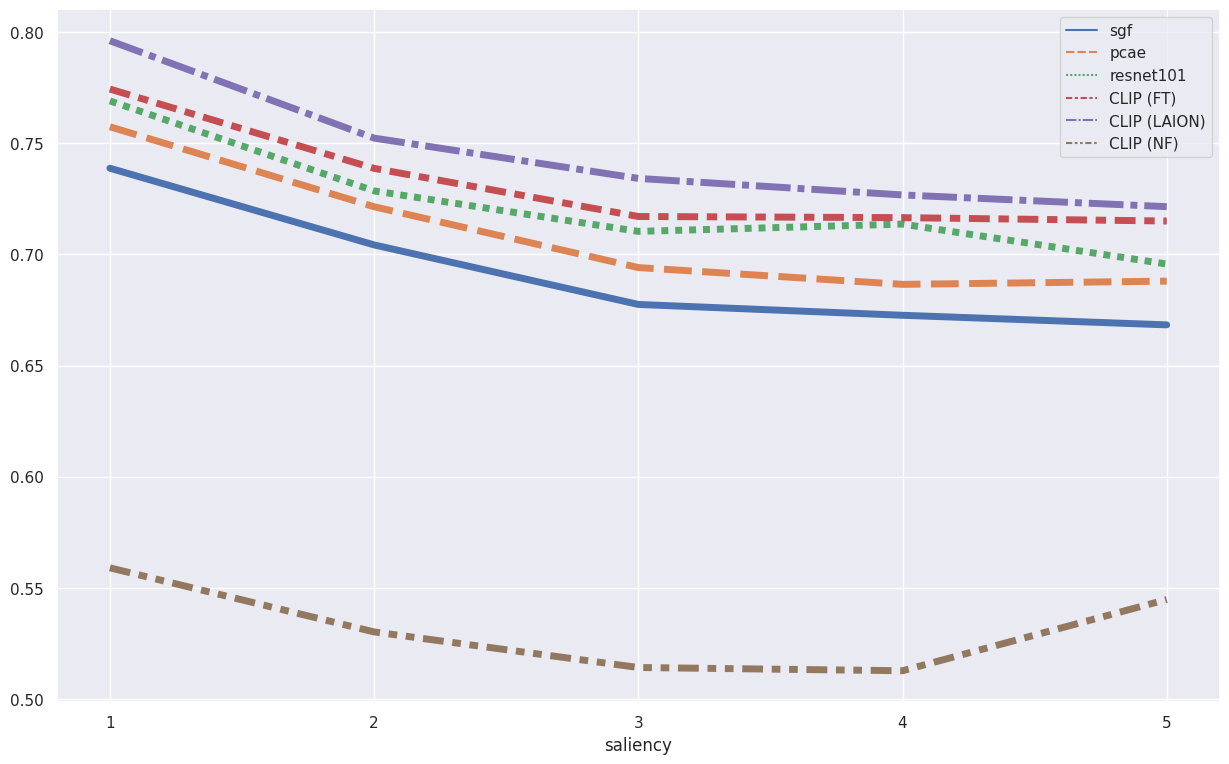

In [18]:
sns.set(font_scale=1)
plt.figure(figsize=(15,9))
g = sns.lineplot(data=all_saliencies, linewidth=5)
g.set_xticks(range(5))
g.set_xticklabels(range(1, 6))
plt.setp(g.get_legend().get_texts())